## Face Mask Detection with Tensorflow

### Loading Necessary Imports

In [3]:
import os
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import tensorflow as tf


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display
import shutil


print("Version: ", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.12.0
GPU is NOT AVAILABLE


### Downloading Dataset

In [ ]:
# istalling kaggle and uploading api key to download dataset directly in collab
! pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
# making a directory named kaggle and save api key json file there
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle

In [ ]:
# changing permisssion of the json file
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# verfiying if I am able to access kaggle
! kaggle datasets list

ref                                                        title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/top-spotify-songs-2023                    Most Streamed Spotify Songs 2023              47KB  2023-08-26 11:04:57          10209        333  1.0              
carlmcbrideellis/zzzs-lightweight-training-dataset-target  Zzzs: Lightweight training dataset + target  185MB  2023-09-11 07:21:51            353         50  1.0              
muhammadtalhaawan/world-export-and-import-dataset          World Export & Import Dataset (1989 - 2023)  721KB  2023-09-09 18:59:41           1124         32  1.0              
josephinelsy/spotify-top-hit-playlist-2010-2022            Spotify Top Hit Playlist (2010-2022)         210KB  2023-09-0

In [ ]:
# downloadig the particular dataset using the api command from the datset page
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

100% 329M/330M [00:12<00:00, 26.0MB/s]
100% 330M/330M [00:12<00:00, 28.3MB/s]


In [ ]:
# unzipping the data
import zipfile
zip_ref = zipfile.ZipFile('face-mask-12k-images-dataset.zip', 'r')
zip_ref.extractall('/content/datasets')
zip_ref.close()

### Configurations

In [6]:
PATH = os.getcwd() # make sure it poits to home
DATA_PATH = PATH + '/dataset/Face Mask Dataset'

LR = 0.001
BATCH_SIZE = 8
EPOCHS = 15
TARGET_SIZE = (256,256)
NUM_CLASSES = 2


### Utility Functions

In [14]:
# function to count parameters of a model

def count_params(model):
    non_trainable_params = np.sum([np.prod(v.get_shape().as_list())
                                    for v in model.non_trainable_weights])
    trainable_params = np.sum([np.prod(v.get_shape().as_list())
                                    for v in model.trainable_weights])
    print(non_trainable_params,trainable_params)
    return {'non_trainable_params': non_trainable_params,'trainable_params': trainable_params}


In [7]:
# function to save figures

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    os.chdir(PATH)
    IMAGES_PATH = PATH +'/images'

    if os.path.isdir(IMAGES_PATH) is False:
        os.mkdir('images')
        IMAGES_PATH = PATH + '/images'
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)

    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return

In [16]:
# function for ploting training

def plot_training(history,name):
    hist = pd.DataFrame()
    hist["Train Loss"]=history.history['loss']
    hist["Validation Loss"]=history.history['val_loss']
    hist["Train Accuracy"]=history.history['accuracy']
    hist["Validation Accuracy"]=history.history['val_accuracy']

    fig, axarr=plt.subplots(nrows=2, ncols=1 ,figsize=(8,6))
    axarr[0].set_title("History of Loss in Train and Validation Datasets")
    hist[["Train Loss", "Validation Loss"]].plot(ax=axarr[0])
    axarr[1].set_title("History of Accuracy in Train and Validation Datasets")
    hist[["Train Accuracy", "Validation Accuracy"]].plot(ax=axarr[1])
    save_fig(name)
    plt.show()

In [17]:
# ploting the outputs using confusion matrix

def plot_confusion(y_test,y_predict,name):
	cm = confusion_matrix(y_test, y_predict)
	class_names=[0,1,2,3,4,5,6,7,8,9]
	fig, ax = plt.subplots(figsize=(6,6))
	tick_marks = np.arange(len(class_names))
	plt.xticks(tick_marks, class_names)
	plt.yticks(tick_marks, class_names)
	sns.heatmap(pd.DataFrame(cm), annot=True, cmap="Purples" ,fmt='g')
	ax.xaxis.set_label_position("top")
	plt.tight_layout()
	plt.title('Confusion Matrix', y=1.1)
	plt.ylabel('Actual label')
	plt.xlabel('Predicted label')
	save_fig(name)
	plt.show()
	return

Saving figure train_imgs


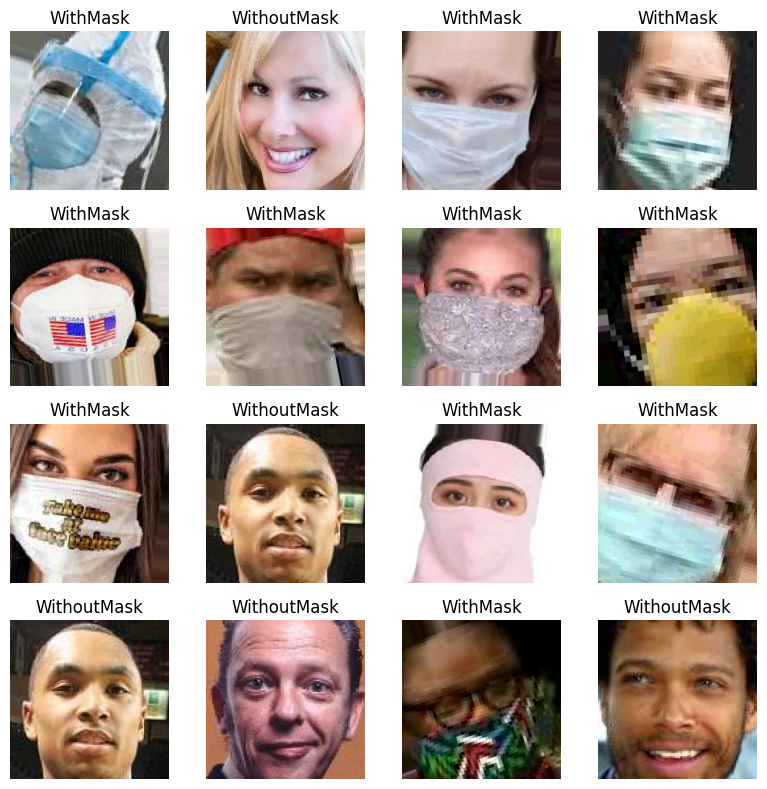

In [18]:
# ploting images from train dir

def plot_images(PATH):
  images = []
  for folder in os.listdir(PATH):
    for image in os.listdir(PATH + '/' + folder):
      images.append((os.path.join(PATH, folder, image), folder))

  plt.figure(1, figsize=(8, 8))

  for i in range(16):
    i += 1

    random_img = random.choice(images)
    imgs = plt.imread(random_img[0])
    plt.subplot(4, 4,i)
    plt.axis('off')
    plt.title(random_img[1])
    plt.imshow(imgs)
  save_fig('train_imgs')
  plt.show()


plot_images(DATA_PATH + '/Train')

Saving figure count_plt


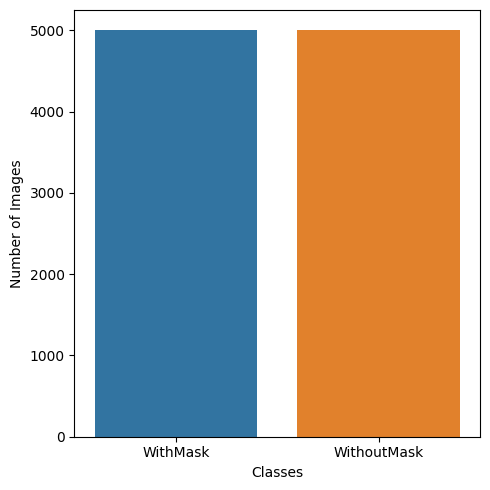

In [19]:
# image distribution

def count_plot(path):
  class_counts = {}

  for subdir in os.listdir(path):
      subdir_path = os.path.join(path, subdir)
      class_counts[subdir] = len(os.listdir(subdir_path))

  fig = plt.figure(figsize=(5, 5))

  sns.barplot(x=list(class_counts.keys()), y =list(class_counts.values()),data=None)
  plt.xlabel('Classes')
  plt.ylabel('Number of Images')
  save_fig('count_plt')
  plt.show()


count_plot(DATA_PATH +'/Train')

Saving figure pie_chart


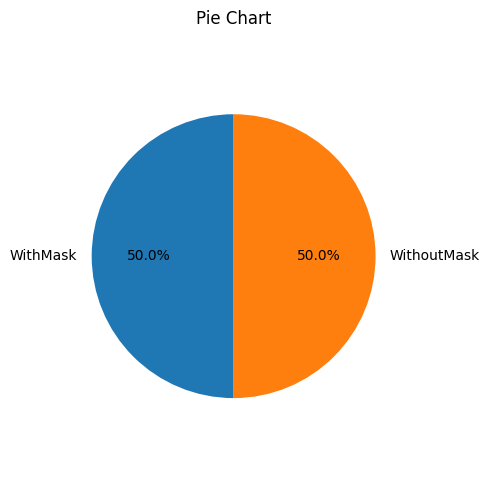

In [20]:
# pie chart to view image distribution visually

def pie_chart(path):
        os.chdir(path)
        list_dir = []
        list_dir = os.listdir(os.getcwd())
        count = {}
        for dir in list_dir:
                file = os.listdir(os.getcwd()+'/' +dir)
                count[dir] = len(file)

        fig = plt.figure(figsize=(5, 5))

        plt.pie(list(count.values()), labels=list(count.keys()), autopct='%1.1f%%',
                startangle=90.0,radius=15.0)

        plt.axis('equal')
        plt.title("Pie Chart")
        save_fig('pie_chart')
        plt.show()
        return

pie_chart(DATA_PATH + '/Train')
# Validation Data also has almost same distriibution but test data is uniform

Saving figure face_detection


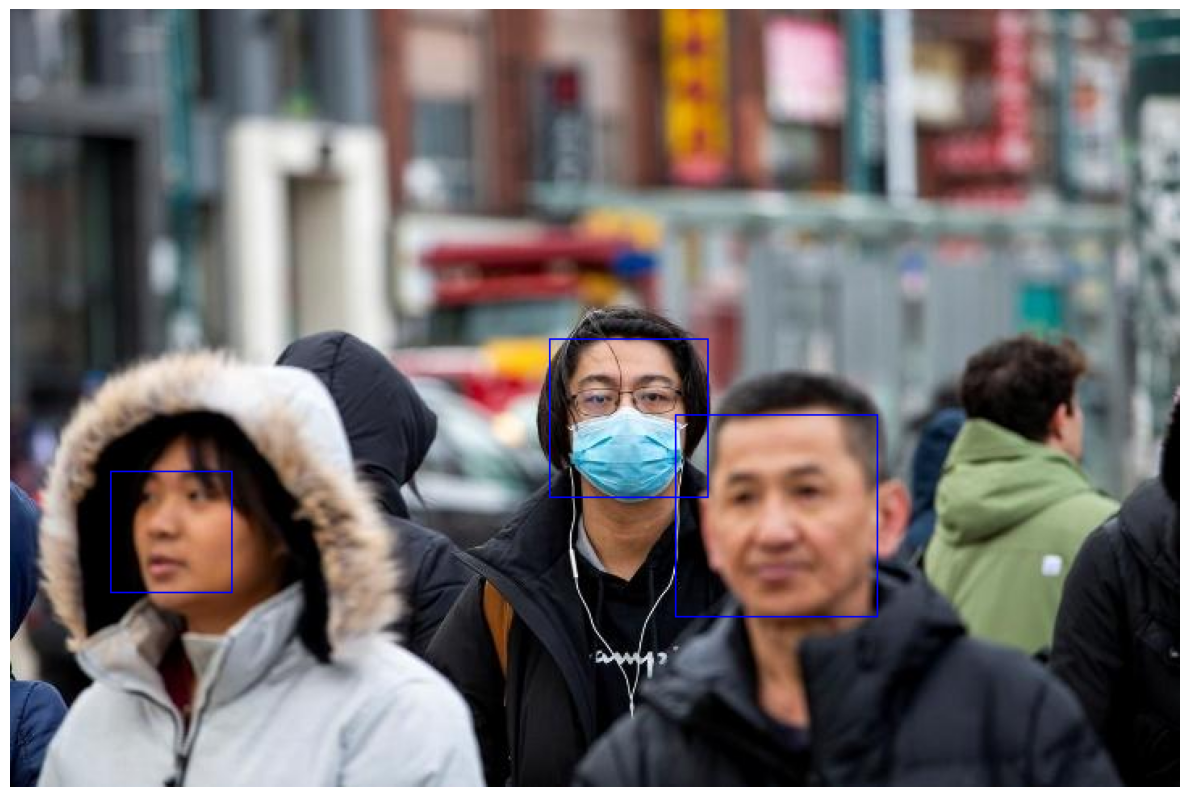

In [55]:
import cv2
#trying it out on a sample image
face_model = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
img = cv2.imread('images/test.jpg')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=10) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.axis('off')
save_fig('face_detection')
plt.imshow(out_img)

### Create Batches

In [28]:
# function to create test, train and valid batches

from keras.preprocessing.image import ImageDataGenerator

def create_batches(path):
    train_path = path + '/Train'
    test_path = path + '/Test'
    valid_path = path + '/Validation'

    #  Create a data augmentor
    data_augmentor = ImageDataGenerator(
                                samplewise_center=True,
                                rescale=1./255,
                                shear_range=0.2,
                                zoom_range = 0.2,
                                samplewise_std_normalization=True)



    train_batches = data_augmentor.flow_from_directory(
                                                directory=train_path,
                                                target_size=TARGET_SIZE,
                                                batch_size=BATCH_SIZE,
                                                class_mode='binary')


    test_batches = data_augmentor.flow_from_directory(
                                                directory=test_path,
                                                target_size=TARGET_SIZE,
                                                shuffle=False,
                                                batch_size=BATCH_SIZE,
                                                class_mode='binary')

    valid_batches = data_augmentor.flow_from_directory(
                                                        directory=valid_path,
                                                        target_size=TARGET_SIZE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='binary')

    return (train_batches,test_batches,valid_batches)


PATH = DATA_PATH
train_batches,test_batches,valid_batches = create_batches(PATH)

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Model Creation

In [29]:
# function for model creation

from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.applications.vgg19 import VGG19
def create_model():

    vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(256,256,3))

    for layer in vgg19.layers:
        layer.trainable = False
        
    model = Sequential()
    model.add(vgg19)
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    model.summary()

    return model

In [30]:
model = create_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 32769     
                                                                 
Total params: 20,057,153
Trainable params: 32,769
Non-trainable params: 20,024,384
_________________________________________________________________


### Model Training

In [31]:
def train_and_evaluate_model(model):

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.losses.BinaryCrossentropy(),
                  metrics=[tf.metrics.BinaryAccuracy(name='accuracy')])

    history = model.fit(train_batches,
                        epochs= EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_data=valid_batches,
                        callbacks=[
                                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode='min')
                        ], verbose =0)
    return (history, model)

In [32]:
history, trained_model = train_and_evaluate_model(model)

Saving figure vgg19_train


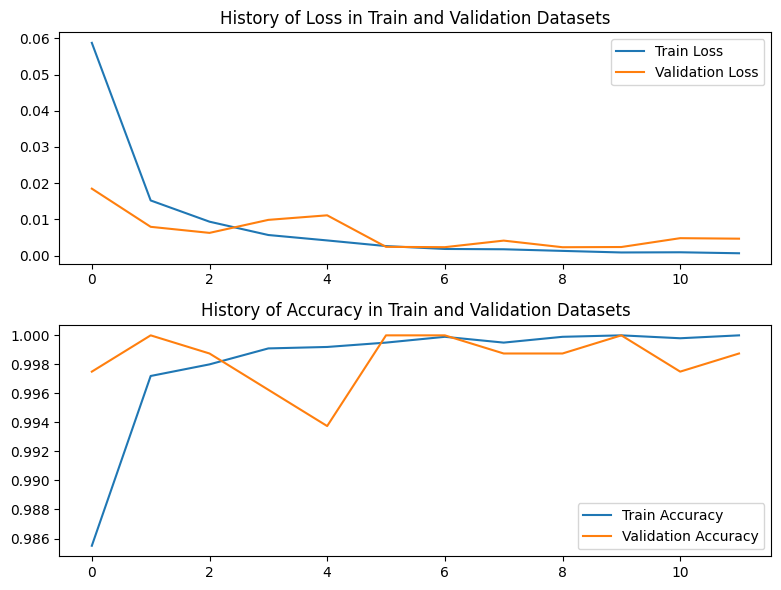

In [36]:
plot_training(history, "vgg19_train")

### Model Testing

124/124 [==============================] - 132s 1s/step
Saving figure base_conv


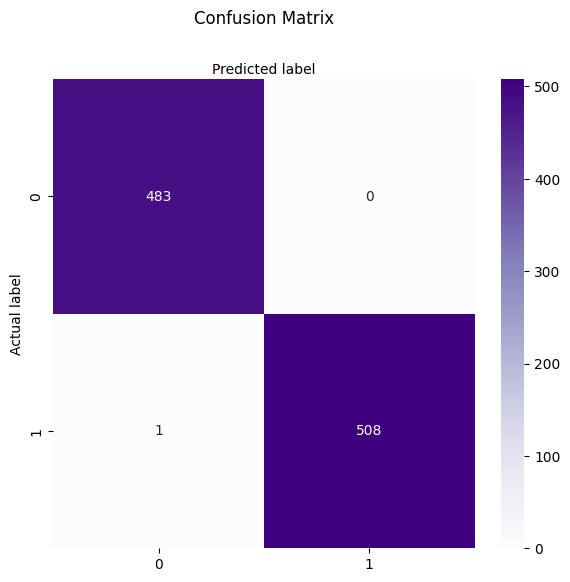

In [35]:
test_labels = test_batches.classes
predictions = trained_model.predict(test_batches)
y_pred= np.round(predictions)
plot_confusion(test_labels,y_pred, 'base_conv')

### Saving Model

In [ ]:
# saving model
M_PATH = PATH + '/models'
model.save(M_PATH + "vgg16.h5")

In [9]:
from keras.models import load_model
model = load_model('models/vgg16.h5')

### Making Predictions


In [44]:
import cv2
from keras.applications.vgg19 import preprocess_input
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def face_detection_frame(img, x, y, w, h, prediction):
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=6)
    output = []

    for (x,y,w,h) in faces:
        cropped_image = img[y:y+h, x:x+w]
        img_arr = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
        img_arr = cv2.resize(img_arr, (256,256), interpolation = cv2.INTER_AREA)
        image = np.expand_dims(img_arr, 0)
        img_arr = preprocess_input(image)
        prediction = model.predict(img_arr)
        output.append([x,y,w,h,prediction])
    return output

### On Camera

In [49]:
# reading from camera
x = -100
y = -100
w = 0
h = 0
prediction = 0

# define a video capture object
vid = cv2.VideoCapture(0)
itera = 0
while(True):

    # Capture the video frame
    # by frame
    ret, frame = vid.read()

    #iterate the detection function once every 5 frames
    itera += 1
    if itera % 5 == 0 or itera <=5 :

        #Function implementation
        output = face_detection_frame(frame, x, y, w, h, prediction)

    for (x,y,w,h,prediction) in output:
        #During the 5 frames we produce the same output of the last function implementation
        if prediction > 0.5 : #If without mask
            cv2.putText(img=frame, text='without mask', org=(x, y+h+30), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0, 255),thickness=2)
            frame = cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)

        else :                #If with mask
            cv2.putText(img=frame, text='with mask', org=(x, y+h+30), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0, 255),thickness=2)
            frame = cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)

    # Display the resulting frame
    cv2.imshow('frame', frame)

    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

1/1 [==============================] - 0s 331ms/step


### On Video

In [52]:
# Reading from a Video File
x = -100
y = -100
w = 0
h = 0
prediction = 0

cap = cv2.VideoCapture("images/video.mp4")
itera = 0
# Check if camera opened successfully
if (cap.isOpened()== False):
    print("Error opening video stream or file")

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:

        itera += 1
        if itera % 5 == 0 or itera <=5 :

            #Function implementation
            output = face_detection_frame(frame, x, y, w, h, prediction)

        for (x,y,w,h,prediction) in output:
            #During the 5 frames we produce the same output of the last function implementation
            if prediction > 0.5 : #If without mask
                cv2.putText(img=frame, text='without mask', org=(x, y+h+30), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.5, color=(0,0,255),thickness=2)
                frame = cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2)

            else :                #If with mask
                cv2.putText(img=frame, text='with mask', org=(x, y+h+30), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.5, color=(255, 0, 0),thickness=2)
                frame = cv2.rectangle(frame,(x,y),(x+w,y+h),(255, 0, 0),2)

        out.write(frame)
        # Display the resulting frame
        cv2.imshow('Frame',frame)

        # Press Q on keyboard to  exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

  # Break the loop
    else:
        break
# When everything done, release the video capture object
cap.release()
out.release()
# Closes all the frames
cv2.destroyAllWindows()

1/1 [==============================] - 0s 306ms/step


### On Image

1/1 [==============================] - 1s 736ms/step
[0.8857781291007996]
1/1 [==============================] - 0s 291ms/step
[0.019294286146759987]
1/1 [==============================] - 0s 294ms/step
[0.7857219576835632]
Saving figure mask_detection2


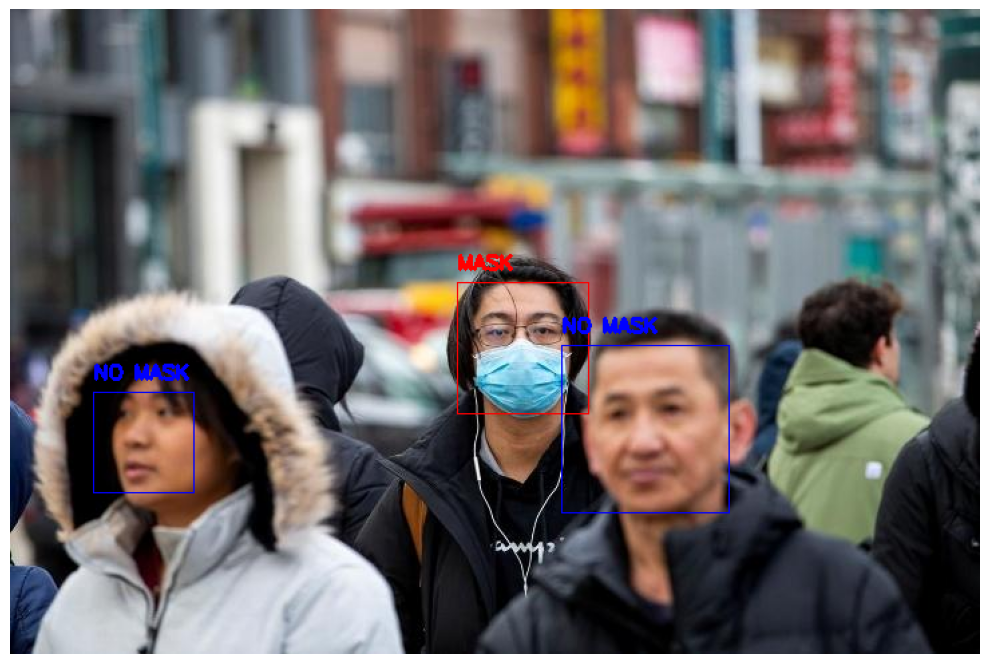

In [10]:
import cv2
mask_label = {0:'MASK',1:'NO MASK'}
shape_color = {0:(255,0,0),1:(0,0,255)}
text_color = {0:(255,0,0),1:(0,0,255)}
#trying it out on a sample image
face_model = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
img = cv2.imread('images/test.jpg')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=10) #returns a list of (x,y,w,h) tuples

new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    crop = new_img[y:y+h,x:x+w]
    crop = cv2.resize(crop,(256,256))
    crop = np.reshape(crop,[1,256,256,3])/255.0
    mask_result = ((model.predict(crop)).flatten()).tolist()
    mask_result1 = round(mask_result[0])
    print(mask_result)

    cv2.putText(new_img,mask_label[mask_result1],(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,text_color[mask_result1],2)
    cv2.rectangle(new_img,(x,y),(x+w,y+h),shape_color[mask_result1],1)
plt.figure(figsize=(10,10))

plt.axis('off')
save_fig('mask_detection2')
plt.imshow(new_img)